In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import bottleneck as bn
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from matplotlib.gridspec import GridSpec

In [71]:
def interpolate(signal, t_sample, interp_time, axis=-1, kind='linear'):
    if axis != -1 :
        func = interp1d(t_sample, signal, fill_value='extrapolate', axis=axis, kind=kind)
    else : 
        func = interp1d(t_sample[np.isfinite(signal)], signal[np.isfinite(signal)], fill_value='extrapolate', kind=kind)
    new_signal = func(interp_time)

    return new_signal

def detect_high_var(trace, window=4, threshold=0.05):
    """ March 2024 - Bacci Lab - faezeh.rabbani97@gmail.com
    - - - - - - - - - - - - - - - Method  - - - - - - - - - - - - - - - - - - -

    This is a function provided by the Bottleneck library in Python.
    The move_var function calculates the moving variance along a given axis
    using a specified window size. The function divides the range of fluctuation
    by 20 to determine a threshold value. Any value above threshold is considered as blinking.

    - - - - - - - - - - - - - - - INPUT - - - - - - - - - - - - - - - - - - - -
    trace                       The input trace
    window                      Size of window to calculate variance inside
    threshold                   Threshold for high variation detection

    - - - - - - - - - - - - - - - OUTPUT - - - - - - - - - - - - - - - - - - -
    high_var_indices            Array of 0s and 1s, where 1 indicates that the corresponding time point has high variation
    """

    high_var_detection = bn.move_var(trace, window=window, min_count=1)
    high_var_detection_norm = (high_var_detection - high_var_detection.min()) / (high_var_detection.max() - high_var_detection.min())
    high_var_indices = [1 if el > threshold else 0 for el in high_var_detection_norm]

    return np.array(high_var_indices)

def remove_blinking(data, params):

    pupil_id = np.arange(len(data['pupil_dilation']))

    data['blinking_ids'] = detect_high_var(data['pupil_dilation'], window=params["window_blink"], threshold=params["threshold_blink"])
    id_without_blinking = np.where(data['blinking_ids'] == 0)[0]

    data['pupil_dilation_blinking_corrected'] = interpolate(data['pupil_dilation'][id_without_blinking], id_without_blinking, pupil_id, kind=params["kind_blink"])
    data['pupil_center_X'] = interpolate(data['pupil_center_X'][id_without_blinking], id_without_blinking, pupil_id)
    data['pupil_center_y'] = interpolate(data['pupil_center_y'][id_without_blinking], id_without_blinking, pupil_id)
    data['width'] = interpolate(data['width'][id_without_blinking], id_without_blinking, pupil_id)
    data['height'] = interpolate(data['height'][id_without_blinking], id_without_blinking, pupil_id)

def remove_noise(data, params):

    pupil_id = np.arange(len(data['pupil_dilation']))
    #trace = (data['pupil_center'][:, 0] - data['pupil_center'][:, 0].mean()) * (data['pupil_center'][:, 1] - data['pupil_center'][:, 1].mean()) * (data['width'] - data['width'].mean()) * (data['height'] - data['height'].mean())
    #trace = (data['width'] - data['width'].mean()) * (data['height'] - data['height'].mean())
    trace = (data['pupil_center_X'] - data['pupil_center_X'].mean()) * (data['pupil_center_y'] - data['pupil_center_y'].mean())
    high_var_ids = detect_high_var(trace, window=params["window_noise"], threshold=params["threshold_noise"])

    id_without_high_var = np.where(high_var_ids == 0)[0]

    #data['pupil_dilation_blinking_corrected'] = interpolate(data['pupil_dilation_blinking_corrected'][id_without_high_var], id_without_high_var, pupil_id, kind=params["kind_noise"])
    data['pupil_center_X'] = interpolate(data['pupil_center_X'][id_without_high_var], id_without_high_var, pupil_id, kind=params["kind_noise"])
    data['pupil_center_y'] = interpolate(data['pupil_center_y'][id_without_high_var], id_without_high_var, pupil_id, kind=params["kind_noise"])
    #data['width'] = interpolate(data['width'][id_without_high_var], id_without_high_var, pupil_id, kind=params["kind_noise"])
    #data['height'] = interpolate(data['height'][id_without_high_var], id_without_high_var, pupil_id, kind=params["kind_noise"])
    trace_corrected = interpolate(trace[id_without_high_var], id_without_high_var, pupil_id, kind=params["kind_noise"])

    return trace, trace_corrected, high_var_ids

def smooth(data, params):
    data['pupil_dilation_blinking_corrected'] = gaussian_filter1d(data['pupil_dilation_blinking_corrected'], params["window_smooth"])
    data['width'] = gaussian_filter1d(data['width'], params["window_smooth"])
    data['height'] = gaussian_filter1d(data['height'], params["window_smooth"])
    data['pupil_center_X'] = gaussian_filter1d(data['pupil_center_X'], params["window_smooth"])
    data['pupil_center_y'] = gaussian_filter1d(data['pupil_center_y'], params["window_smooth"])
    
def draw_pupil(data, frame, label='', show=True, color='b', color_center='r'):
    x = np.linspace(data['pupil_center_X'][frame] - data['width'][frame], data['pupil_center_X'][frame] + data['width'][frame], 1000)
    y = np.sqrt(data['height'][frame]**2 * (1 - (x-data['pupil_center_X'][frame])**2 / data['width'][frame]**2)) + data['pupil_center_y'][frame]
    y2 = - np.sqrt(data['height'][frame]**2 * (1 - (x-data['pupil_center_X'][frame])**2 / data['width'][frame]**2)) + data['pupil_center_y'][frame] 
    plt.scatter(data['pupil_center_X'][frame], data['pupil_center_y'][frame], color=color_center, marker='x') 
    plt.scatter(x, y, color=color, label=label)
    plt.scatter(x, y2, color=color)
    if show :
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()


# Visualize FaceIt Data

## Load Data

In [84]:
basepath = r"P:\raw-imaging\Nathan\2025_09_29\TSeries-09292025-292fod-006" # Change this to data basepath
filepath = os.path.join(basepath, "FaceIt", "faceit.npz") # Faceit folder outside of FaceCamera-imgs folder
data = np.load(filepath, allow_pickle=True)
fs = 30
time = np.arange(len(data['pupil_dilation'])) / fs
data = dict(data)
data.keys()

dict_keys(['pupil_center', 'pupil_center_X', 'pupil_center_y', 'pupil_dilation_blinking_corrected', 'pupil_dilation', 'X_saccade', 'Y_saccade', 'pupil_distance_from_corner', 'width', 'height', 'motion_energy', 'motion_energy_without_grooming', 'grooming_ids', 'grooming_threshold', 'blinking_ids', 'angle', 'Face_frame', 'Pupil_frame'])

## Pupil

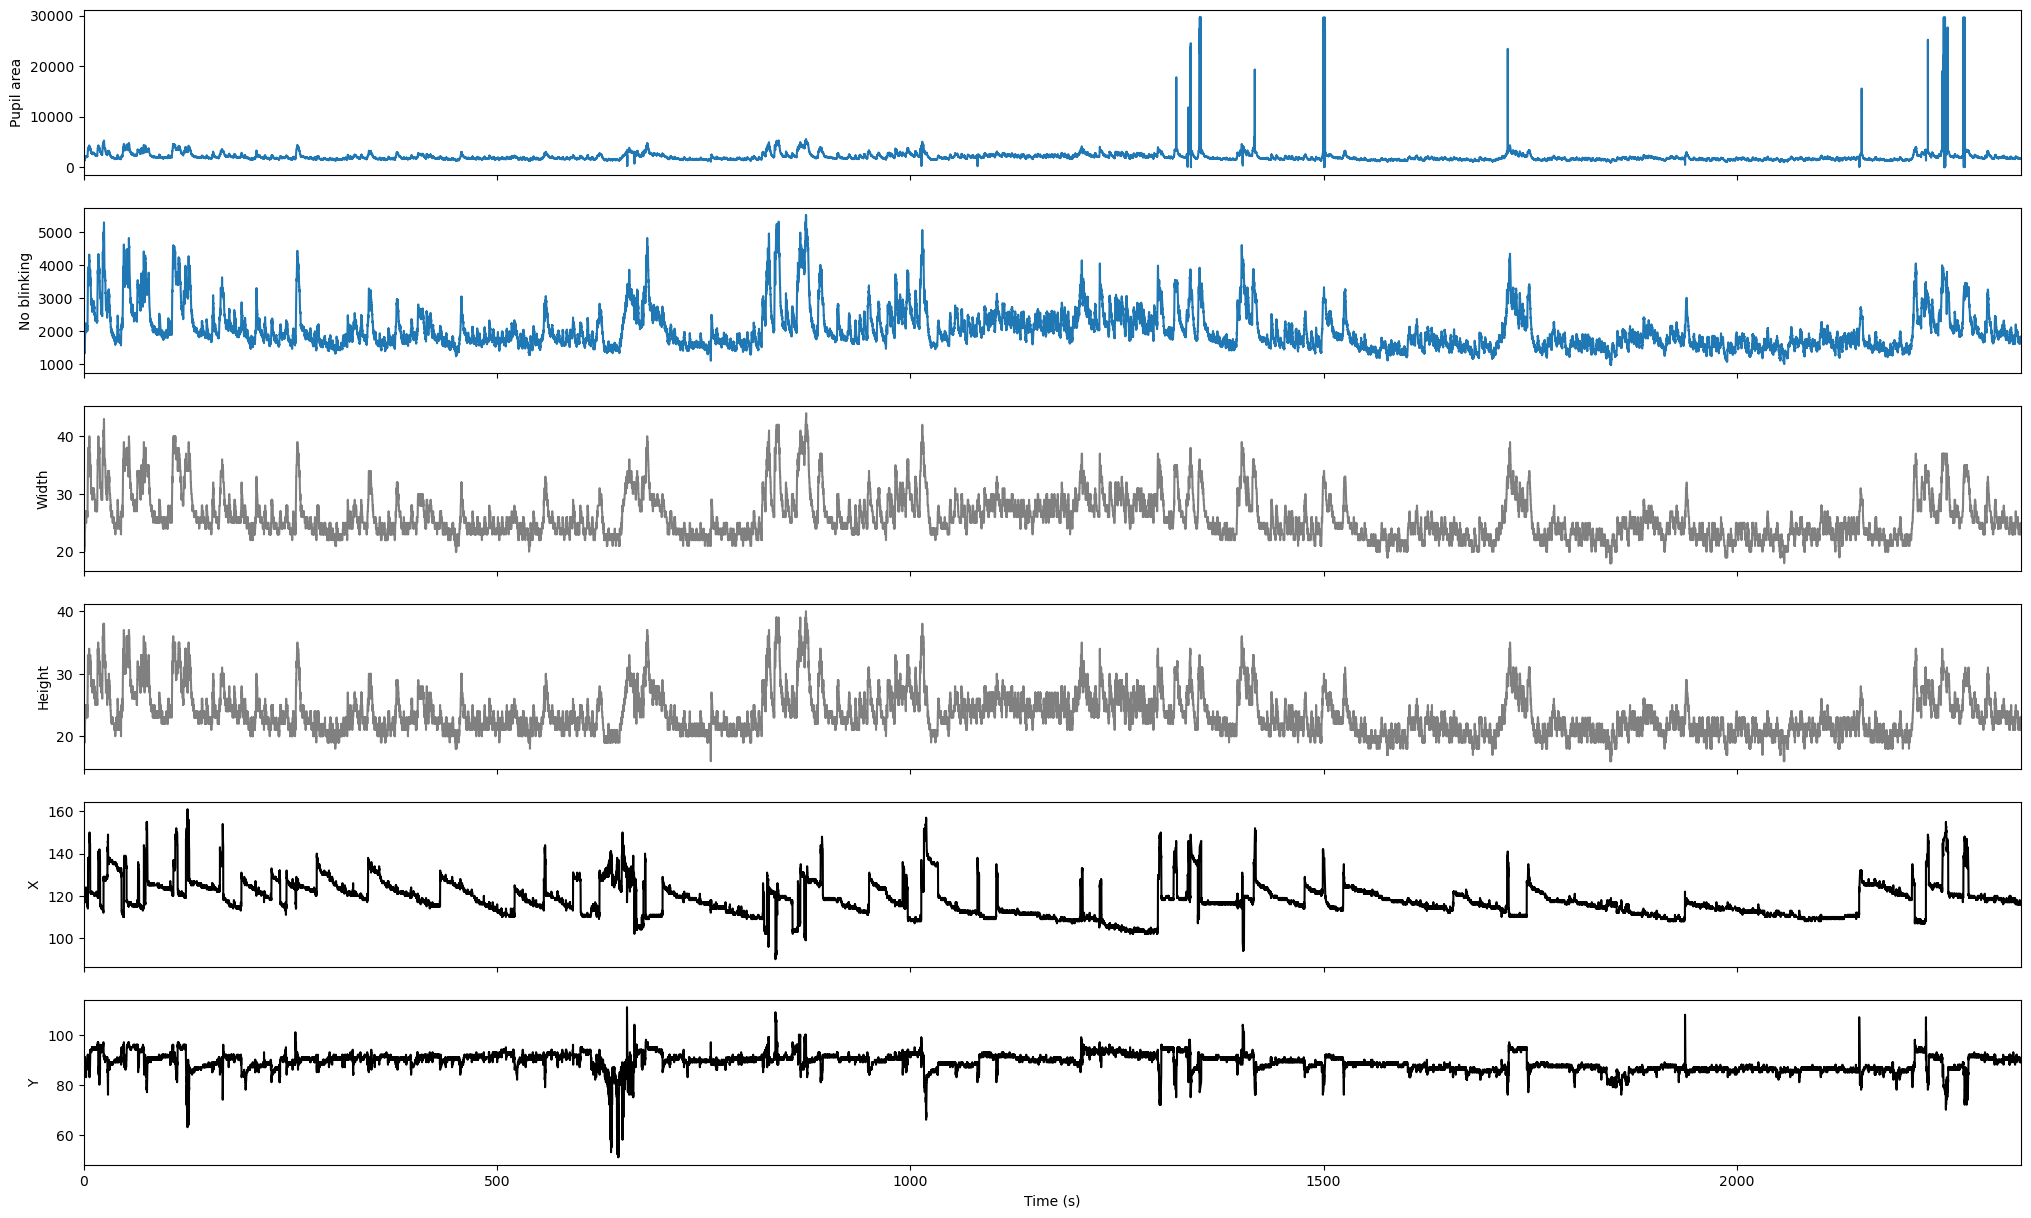

In [87]:
# Visualize pupil traces
fig, ax = plt.subplots(6, 1, figsize=(25, 15), sharex=True)
ax[0].plot(time, data['pupil_dilation'])
ax[0].set_ylabel("Pupil area")
ax[1].plot(time, data['pupil_dilation_blinking_corrected'])
ax[1].set_ylabel("No blinking")
ax[2].plot(time, data['width'], c='gray')
ax[2].set_ylabel("Width")
ax[3].plot(time, data['height'], c='gray')
ax[3].set_ylabel("Height")
ax[4].plot(time, data['pupil_center_X'], c='black')
ax[4].set_ylabel("X")
ax[5].plot(time, data['pupil_center_y'], c='black')
ax[5].set_ylabel("Y")
ax[0].set_xmargin(0)
ax[5].set_xlabel("Time (s)")
plt.show()

### Remove noise if needed

Change parameters value below, in parmas dictionnary. 
- Set remove_blink to True if you want to remove blinking. remove_blinking detect high variation changes (considered as blinking) on the pupil_dilation trace, then remove and interpolate. It not only corrects the pupil_dilation traces but also the width, height and pupil center traces.
- Set remove_noise to True if you want to remove extra noise in the pupil_center traces. remove_noise detect high variation changes on the pupil center coordinates traces, then remove and interpolate.

The threshold values are normalized to be between 0 and 1, e.g. 0.05 means that variation higher than the 5th percentile of the variation will be considered as high variation. Default should be around 0.05.

In [ ]:
params = {"window_blink" : 5, "threshold_blink" : 0.05, "kind_blink" : 'linear', "remove_blink": True,
          "window_noise" : 10, "threshold_noise" : 0.05, "kind_noise" : 'linear', "remove_noise" : False,
          "window_smooth": 2, "smooth": False}
if params["remove_blink"]:
    remove_blinking(data, params)
if params["remove_noise"]:
    remove_noise(data, params)
if params["smooth"]:
    smooth(data, params)

pupil_area = np.pi * data['width'] * data['height']

### Visualize corrections

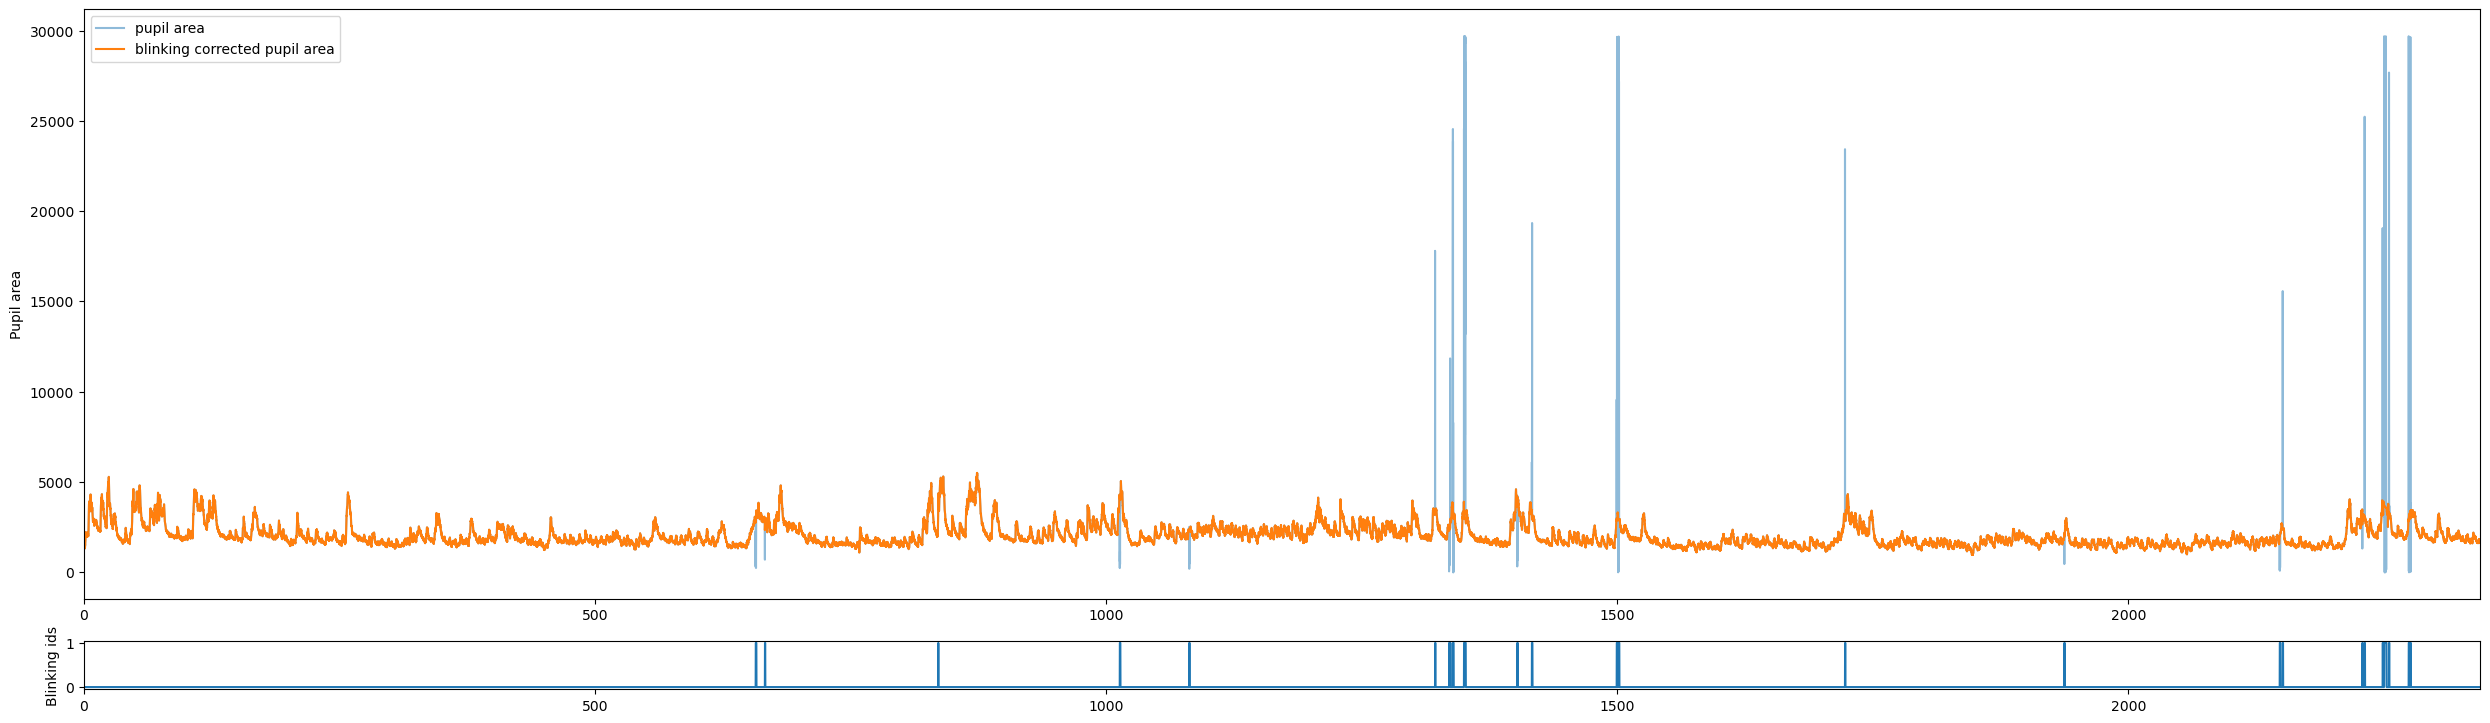

In [86]:
id_without_blinking = np.where(data['blinking_ids'] == 0)[0]

fig = plt.figure(figsize=(25, 8))
gs = GridSpec(9, 1, figure=fig)

ax1 = fig.add_subplot(gs[0:7, 0])  # spans both rows of first column
ax1.plot(time, data['pupil_dilation'], label='pupil area', alpha=0.5)
ax1.plot(time, data['pupil_dilation_blinking_corrected'], label='blinking corrected pupil area')
ax1.legend()
ax1.set_xmargin(0)
ax1.set_ylabel('Pupil area')

ax2 = fig.add_subplot(gs[7, 0], sharex=ax1) 
ax2.plot(time, data['blinking_ids'])
ax2.set_ylabel('Blinking ids')

plt.tight_layout()
plt.show()

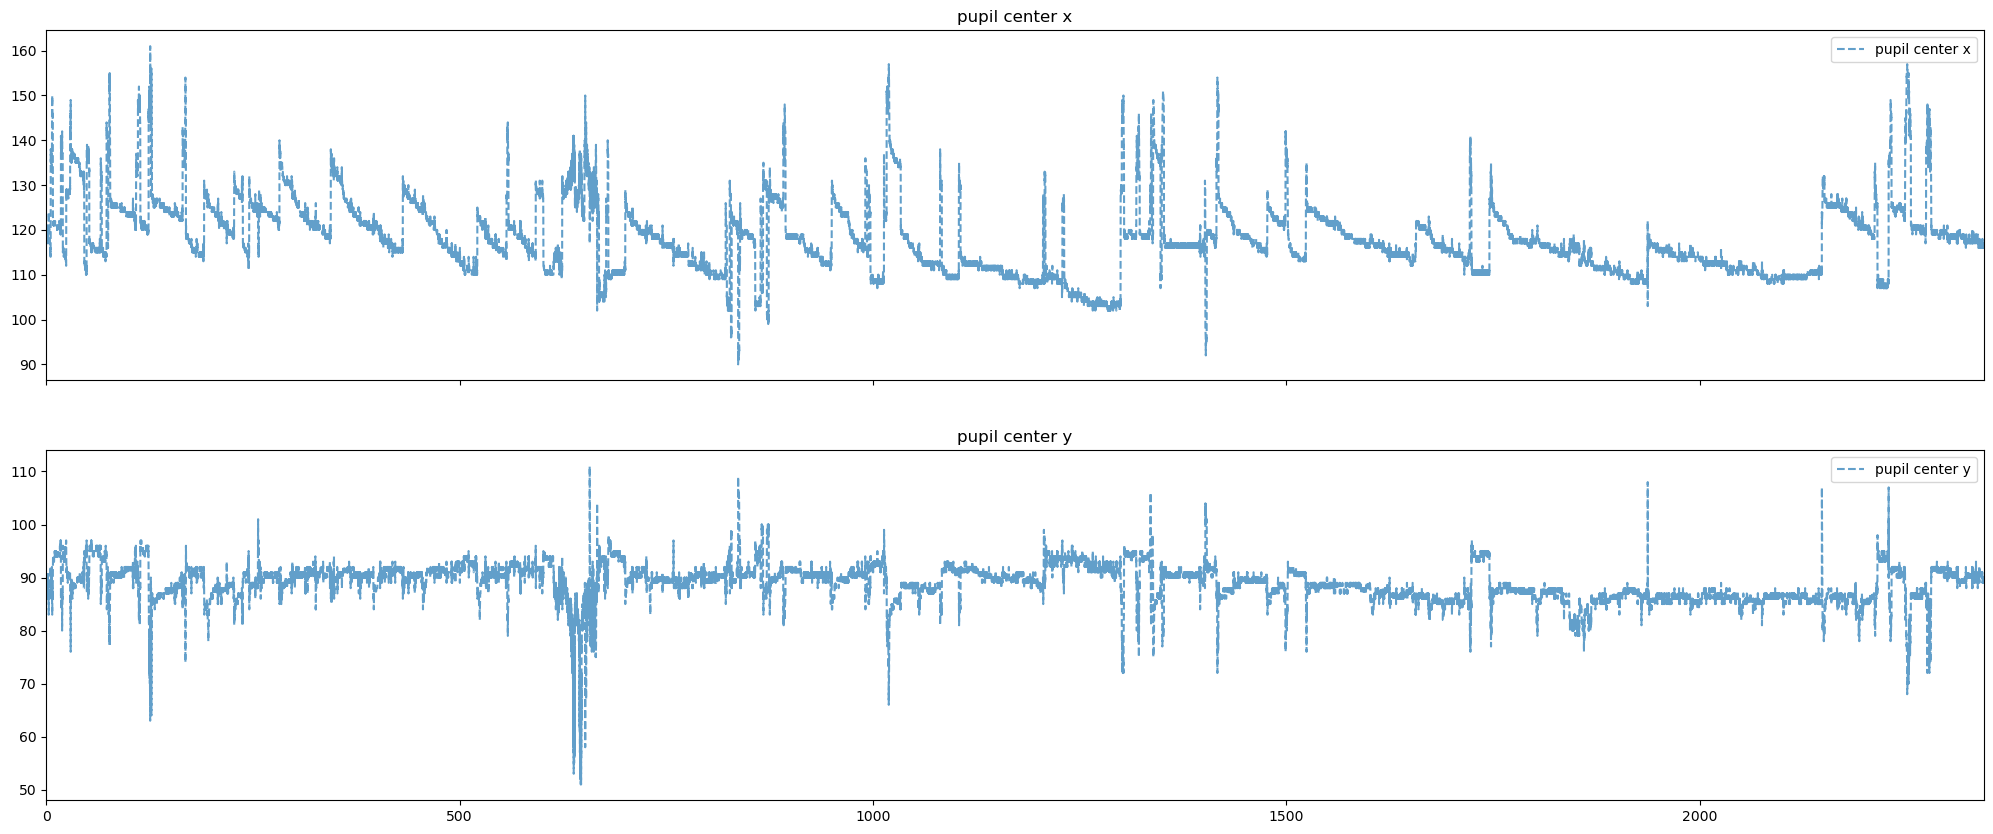

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(25, 10), sharex=True)

axs[0].plot(time, data['pupil_center_X'], label='pupil center x', linestyle='dashed', alpha=0.7)
#axs[0].plot(time, data['pupil_center'][:, 0], label='pupil center x (noise corrected)')
axs[0].set_title('pupil center x')
axs[0].set_xmargin(0)
axs[0].legend()

axs[1].plot(time, data['pupil_center_y'], label='pupil center y', linestyle='dashed', alpha=0.7)
#axs[1].plot(time, data['pupil_center'][:, 1], label='pupil center y (noise corrected)')
axs[1].set_title('pupil center y')
axs[1].legend()

plt.show()

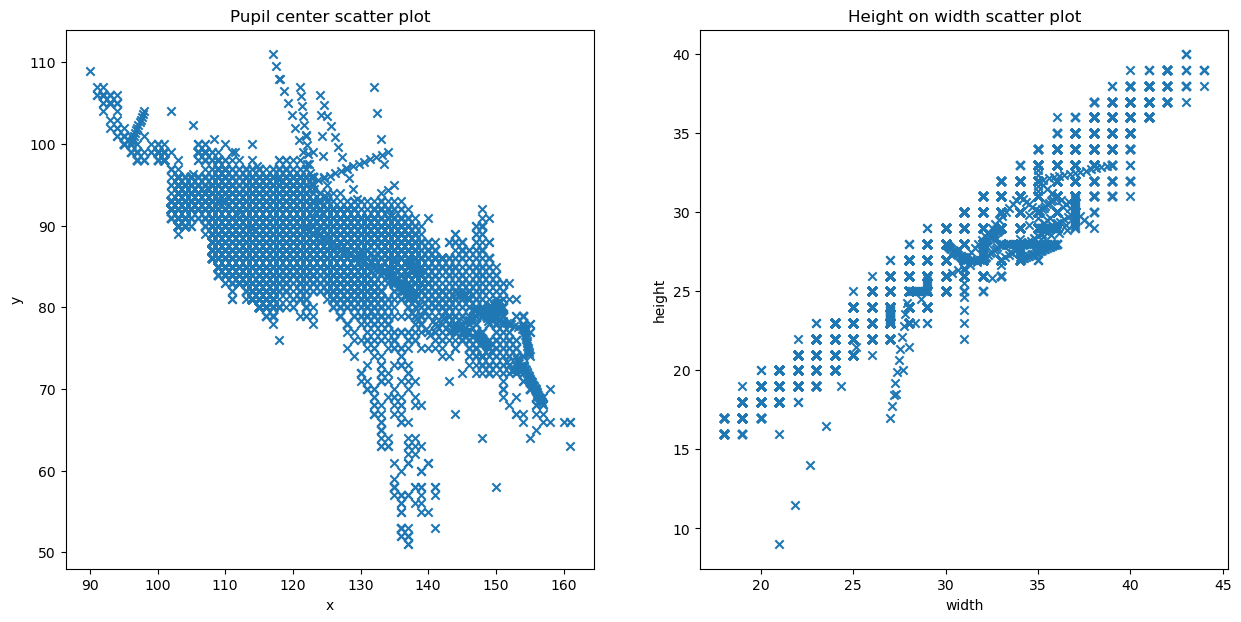

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].scatter(data['pupil_center_X'], data['pupil_center_y'], marker='x')
ax[0].set_title('Pupil center scatter plot')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(data['width'], data['height'], marker='x')
ax[1].set_title('Height on width scatter plot')
ax[1].set_xlabel('width')
ax[1].set_ylabel('height')

plt.show()

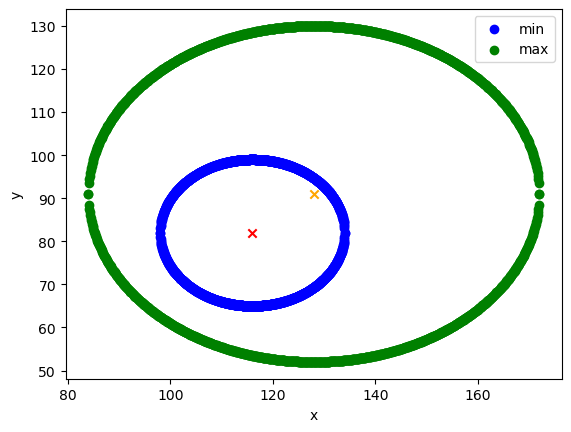

55403 : 30min 46.76666666666662s
26218 : 14min 33.93333333333331s


In [72]:
i, j = np.argmin(data['width']), np.argmax(data['width'])
draw_pupil(data, i, show=False, label='min')
draw_pupil(data, j, color='green', color_center='orange', label='max')

dt = i / 30
print(f"{i} : {int(dt / 60)}min {(dt/60 - int(dt / 60))*60}s")
dt = j / 30
print(f"{j} : {int(dt / 60)}min {(dt/60 - int(dt / 60))*60}s")

In [88]:
# Blinking Intervals
blinking_ids = np.where(data["blinking_ids"] == 1)[0]
intervals = []
start = blinking_ids[0]
for i in range(1, len(blinking_ids)):
    if not blinking_ids[i] == blinking_ids[i-1] + 1 :
        end = blinking_ids[i-1]
        intervals.append((start, end))
        start = blinking_ids[i]
end = blinking_ids[-1]
intervals.append((start, end))

for el in intervals:
    time_str = []
    for idx in el:
        dt = idx/30
        time_str.append(f"{int(dt / 60)}min {(dt/60 - int(dt / 60))*60}s")
    print(f"{el} : {time_str[0]} to {time_str[1]}")

(np.int64(19720), np.int64(19739)) : 10min 57.33333333333334s to 10min 57.96666666666667s
(np.int64(19990), np.int64(19999)) : 11min 6.333333333333364s to 11min 6.633333333333304s
(np.int64(25075), np.int64(25079)) : 13min 55.83333333333332s to 13min 55.966666666666676s
(np.int64(25081), np.int64(25081)) : 13min 56.03333333333335s to 13min 56.03333333333335s
(np.int64(30403), np.int64(30420)) : 16min 53.433333333333266s to 16min 53.999999999999915s
(np.int64(32439), np.int64(32452)) : 18min 1.2999999999998835s to 18min 1.7333333333333911s
(np.int64(39655), np.int64(39664)) : 22min 1.8333333333333002s to 22min 2.1333333333334537s
(np.int64(40066), np.int64(40086)) : 22min 15.533333333333204s to 22min 16.199999999999974s
(np.int64(40096), np.int64(40105)) : 22min 16.53333333333336s to 22min 16.8333333333333s
(np.int64(40176), np.int64(40199)) : 22min 19.200000000000017s to 22min 19.966666666666697s
(np.int64(40503), np.int64(40554)) : 22min 30.09999999999991s to 22min 31.799999999999855s

### Save changes to npz file

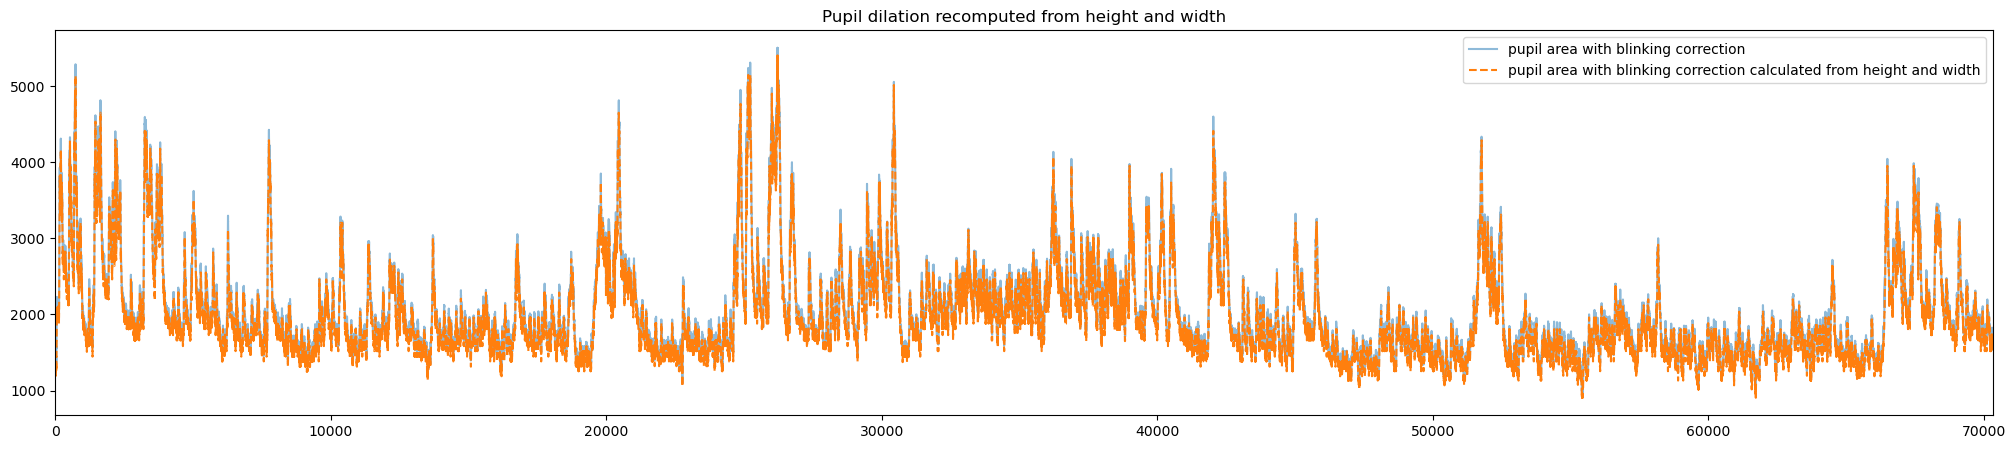

In [89]:
fig = plt.figure(figsize=(25, 5))
plt.plot(data['pupil_dilation_blinking_corrected'], label='pupil area with blinking correction', alpha=0.5)
plt.plot(pupil_area, label='pupil area with blinking correction calculated from height and width', linestyle='dashed')
plt.title('Pupil dilation recomputed from height and width')
plt.margins(0, 0.05)
plt.legend()
plt.show()

When satisfied with the correction, save changes to npz file.

In [91]:
#data['pupil_dilation_blinking_corrected'] = pupil_area #Use only if pupil area seems better when calculated from width and height
#data['pupil_center_X'] = data['pupil_center'][:, 0]
#data['pupil_center_y'] = data['pupil_center'][:, 1]

np.savez_compressed(filepath, **data)

## Facemotion

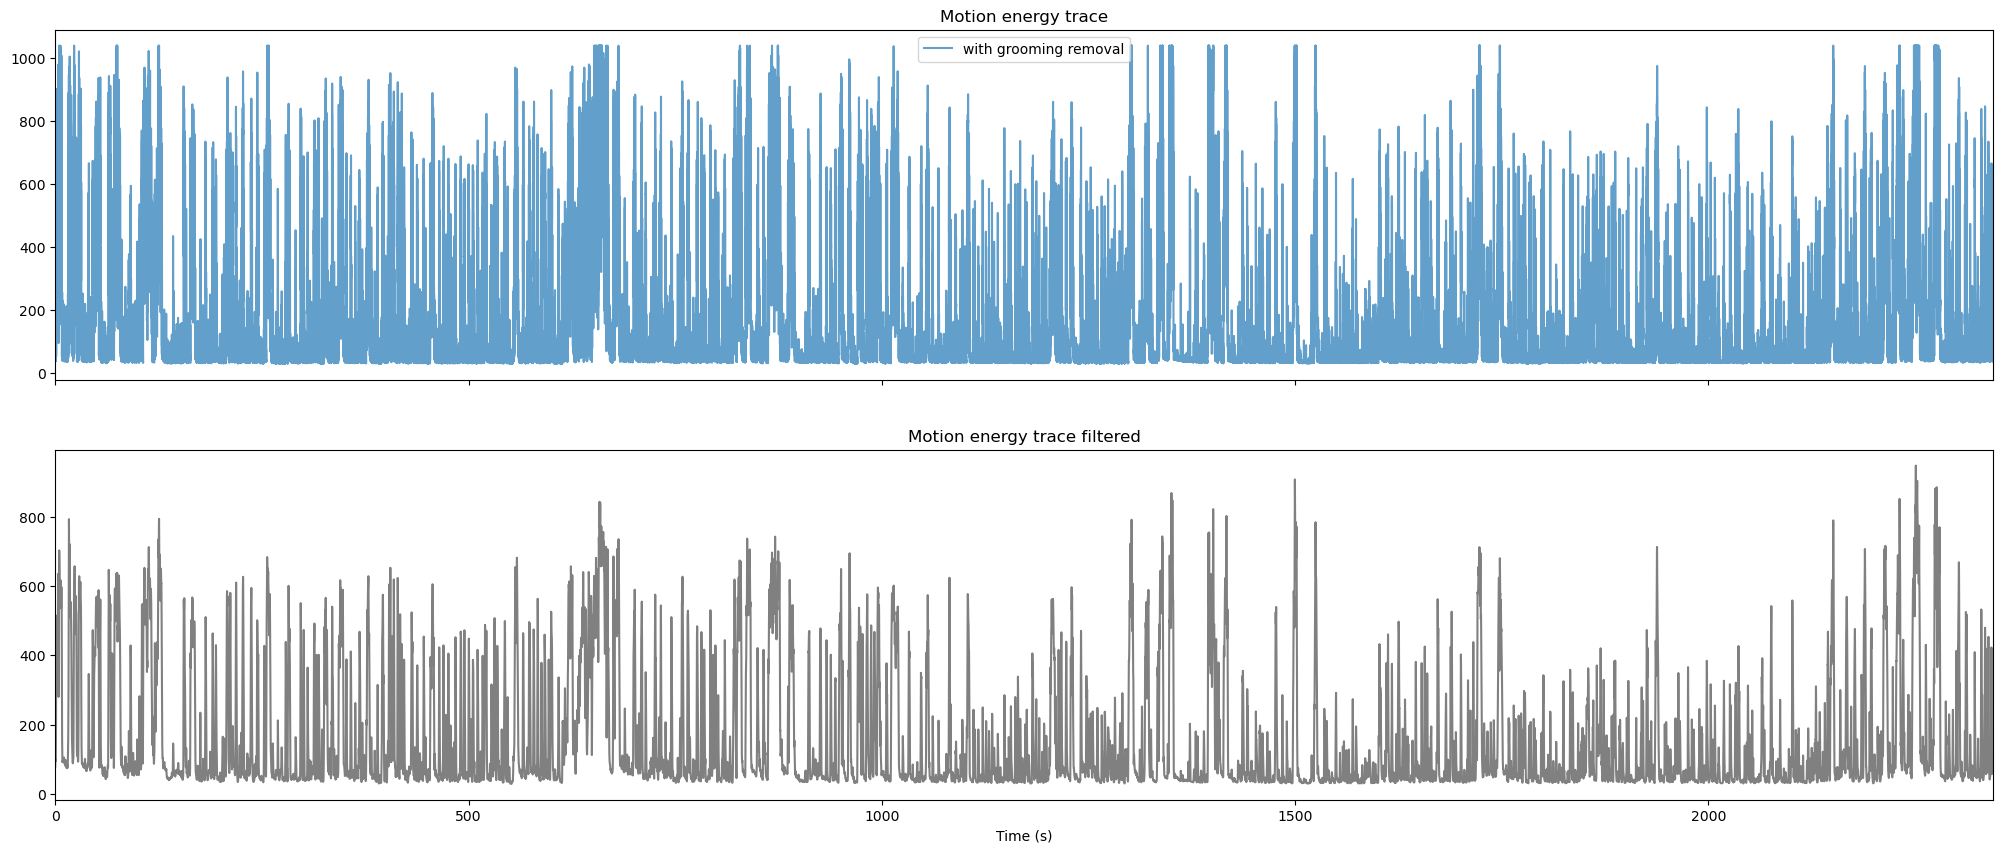

In [90]:
# Visualize pupil traces
fig, ax = plt.subplots(2, 1, figsize=(25, 10), sharex=True)
#ax[0].plot(time, data['motion_energy'], label='without grooming removal')
ax[0].plot(time, data['motion_energy_without_grooming'], alpha=0.7, label='with grooming removal')
ax[1].plot(time, gaussian_filter1d(data['motion_energy_without_grooming'], sigma=5), c='grey')
ax[0].set_title('Motion energy trace')
ax[1].set_title('Motion energy trace filtered')
ax[0].set_xmargin(0)
ax[1].set_xlabel("Time (s)")
ax[0].legend()
plt.show()

In [9]:
if not np.isnan(data['grooming_threshold'][0]):
    print('grooming threshold: ', data['grooming_threshold'][0])
    plt.plot(data['grooming_threshold'])
    plt.show()